In [43]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from pylab import *

In [53]:
london_20 = 'london_square_20'
paris_20 = 'paris_square_20'
toulouse_20 = 'toulouse_square_20'

base_ld = f'./dataset/data_with_building/london_square_20_cell.mat'
base_pr = f'./dataset/data_with_building/{paris_20}_cell.mat'
base_tl = f'./dataset/data_with_building/{toulouse_20}_cell.mat'

In [54]:
meta_ld, cirs_ld, dist_ld, Y_all_ld, RX_all_ld = read_mat(base_ld, london_20)
meta_pr, cirs_pr, dist_pr, Y_all_pr, RX_all_pr = read_mat(base_pr, paris_20)
meta_toul, cirs_toul, dist_toul, Y_all_toul, RX_all_toul = read_mat(base_tl, toulouse_20)

In [55]:
toa = []
for i in cirs_ld:
    toa.append([j[0,0]*3e8 for j in i])

def toa_ex(data):
    toa = []
    for d in data:
        toa.append([di[0,0]*3e8 for di in d])

    return toa

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb
from scipy.optimize import minimize, Bounds
from sklearn.ensemble import AdaBoostRegressor as ABR

In [57]:
def optimize(RX, dist_pred):
    """find x through distance and rx coordinates"""

    def dist2coord(x, coords, dists):

        d = np.array([geodesic(x, coord).m for coord in coords])

        return np.linalg.norm([d-dists])**2

    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for p in dist_pred:
        res = minimize(
        dist2coord,
        RX[0],
        args=(RX, p),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

def cdf_plot(data, ax=plt, label=None):
    n = len(data)
    x = np.arange(n) / (n-1)
    y = np.sort(data)

    ax.plot(y, x, '--',label=label, linewidth=2)
        

In [58]:
toa_pr = toa_ex(cirs_pr)
toa_tl = toa_ex(cirs_toul)

In [59]:
loc_pr = optimize(RX_all_pr, toa_pr)


In [60]:
loc_ld = optimize(RX_all_ld, toa)
loc_pr = optimize(RX_all_pr, toa_ex(cirs_pr))
loc_tl = optimize(RX_all_toul, toa_ex(cirs_toul))

In [61]:
# e_ld = dist_from_geo(loc_ld, Y_all_ld)
e_pr = dist_from_geo(loc_pr, Y_all_pr)

In [38]:
e_tl = dist_from_geo(loc_tl, Y_all_toul)

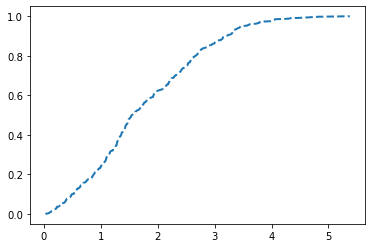

In [42]:
cdf_plot(e_tl)

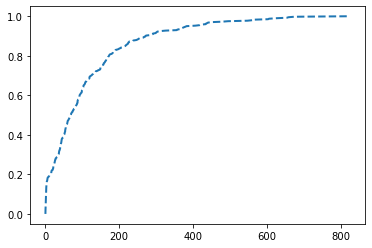

In [63]:
cdf_plot(e_ld)
# cdf_plot(e_pr)
# cdf_plot(e_tl)

# Fingerprint

In [64]:

lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])


In [ ]:
x_train, x_test, y_train, y_test, tx_train, tx_test = train_test_split(X_, Y, Y, train_size=.75)
